In [1]:
import os

In [2]:
%pwd

'D:\\Desktop\\Superteams AI\\Task 2 Vector Databases can help with Anomaly Detection\\Vector-Databases-can-help-with-Anomaly-Detection\\Research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'D:\\Desktop\\Superteams AI\\Task 2 Vector Databases can help with Anomaly Detection\\Vector-Databases-can-help-with-Anomaly-Detection'

In [5]:
import logging
from pathlib import Path
logging.basicConfig(
    # filename='extract_data.log',
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [6]:
import pandas as pd

# Load the CSV file into a pandas DataFrame
df = pd.read_csv("Dataset/financial_news.csv")
df.head()

,title,summary,link,published
0,India's exports dip marginally in March; 3.11%...,India's exports dip marginally in March; 3.11%...,https://realtime.rediff.com/news/business/Indi...,1 hour(s) ago
1,Vi expects 5G rollout in 6-9 months after FPO,Vi expects 5G rollout in 6-9 months after FPO\...,https://realtime.rediff.com/news/business/Vi-e...,2 hour(s) ago
2,"Byju's India CEO Arjun Mohan quits, Raveendran...","Byju's India CEO Arjun Mohan quits, Raveendran...",https://realtime.rediff.com/news/business/Byju...,3 hour(s) ago
3,"Sensex, Nifty tank over 1% on concerns over Mi...","Sensex, Nifty tank over 1% on concerns over Mi...",https://realtime.rediff.com/news/business/Sens...,6 hour(s) ago
4,Wholesale inflation inches up marginally to 0....,Wholesale inflation inches up marginally to 0....,https://realtime.rediff.com/news/business/Whol...,7 hour(s) ago


In [7]:
logging.info("Loaded financial news dataset")

2024-04-18 21:56:50 - INFO - Loaded financial news dataset


# Loading embeddding Model

In [8]:
from sentence_transformers import SentenceTransformer

D:\Desktop\Superteams AI\Task 2 Vector Databases can help with Anomaly Detection\Vector-Databases-can-help-with-Anomaly-Detection\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# from transformers import AutoTokenizer, AutoModel
# from pathlib import Path

# def download_model_and_tokenizer(model_name, save_path):
#     """
#     Download and save both the model and the tokenizer to the specified directory.

#     Parameters:
#         model_name (str): Name of the model to download.
#         save_path (str or Path): Path to the directory where the model and tokenizer will be saved.
#     """
#     # Create the save path if it doesn't exist
#     save_path = Path(save_path)
#     save_path.mkdir(parents=True, exist_ok=True)
    
#     # Initialize tokenizer and model
#     tokenizer = AutoTokenizer.from_pretrained(model_name)
#     model = AutoModel.from_pretrained(model_name)
    
#     # Save tokenizer
#     tokenizer.save_pretrained(save_path)
    
#     # Save model
#     model.save_pretrained(save_path)

# # Example usage
# model_name = 'sentence-transformers/all-MiniLM-L12-v2'  # Model name to download
# save_path = Path("MiniLM-L12-v2/")  # Path where model and tokenizer will be saved
# download_model_and_tokenizer(model_name, save_path)


In [10]:
from transformers import AutoTokenizer, AutoModel

def load_model_and_tokenizer(model_path):
    """
    Load the model and tokenizer from the specified directory.

    Parameters:
        model_path (str or Path): Path to the directory containing the saved model and tokenizer.

    Returns:
        tokenizer (transformers.PreTrainedTokenizer): Loaded tokenizer.
        model (transformers.PreTrainedModel): Loaded model.
    """
    model_path = Path(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModel.from_pretrained(model_path)
    return tokenizer, model

# Load the model and tokenizer
model_path = Path("MiniLM-L12-v2/")
tokenizer, model = load_model_and_tokenizer(model_path)

In [11]:
logging.info("Initialized SentenceTransformer model")

2024-04-18 21:57:00 - INFO - Initialized SentenceTransformer model


In [12]:
df['news'] = df.apply(lambda row: row['title'] + ' ' + row['summary'], axis=1)
df.head()

,title,summary,link,published,news
0,India's exports dip marginally in March; 3.11%...,India's exports dip marginally in March; 3.11%...,https://realtime.rediff.com/news/business/Indi...,1 hour(s) ago,India's exports dip marginally in March; 3.11%...
1,Vi expects 5G rollout in 6-9 months after FPO,Vi expects 5G rollout in 6-9 months after FPO\...,https://realtime.rediff.com/news/business/Vi-e...,2 hour(s) ago,Vi expects 5G rollout in 6-9 months after FPO ...
2,"Byju's India CEO Arjun Mohan quits, Raveendran...","Byju's India CEO Arjun Mohan quits, Raveendran...",https://realtime.rediff.com/news/business/Byju...,3 hour(s) ago,"Byju's India CEO Arjun Mohan quits, Raveendran..."
3,"Sensex, Nifty tank over 1% on concerns over Mi...","Sensex, Nifty tank over 1% on concerns over Mi...",https://realtime.rediff.com/news/business/Sens...,6 hour(s) ago,"Sensex, Nifty tank over 1% on concerns over Mi..."
4,Wholesale inflation inches up marginally to 0....,Wholesale inflation inches up marginally to 0....,https://realtime.rediff.com/news/business/Whol...,7 hour(s) ago,Wholesale inflation inches up marginally to 0....


# embedding the data 

In [13]:
import torch

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

def generate_embedding(text):
    # Tokenize input text
    encoded_input = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    # Compute token embeddings with model
    with torch.no_grad():
        model_output = model(**encoded_input)
    # Perform mean pooling
    sentence_embedding = mean_pooling(model_output, encoded_input['attention_mask'])
    # Convert to numpy for FAISS compatibility and ensure it's 2D
    return sentence_embedding.cpu().numpy().reshape(1, -1)

In [14]:
# Generate embeddings for the 'input' column
df['encoded_news'] = df['news'].apply(lambda x: generate_embedding(x)[0].tolist())
df.head()

,title,summary,link,published,news,encoded_news
0,India's exports dip marginally in March; 3.11%...,India's exports dip marginally in March; 3.11%...,https://realtime.rediff.com/news/business/Indi...,1 hour(s) ago,India's exports dip marginally in March; 3.11%...,"[0.11521313339471817, -0.300284206867218, -0.0..."
1,Vi expects 5G rollout in 6-9 months after FPO,Vi expects 5G rollout in 6-9 months after FPO\...,https://realtime.rediff.com/news/business/Vi-e...,2 hour(s) ago,Vi expects 5G rollout in 6-9 months after FPO ...,"[-0.11326470226049423, -0.1829032599925995, 0...."
2,"Byju's India CEO Arjun Mohan quits, Raveendran...","Byju's India CEO Arjun Mohan quits, Raveendran...",https://realtime.rediff.com/news/business/Byju...,3 hour(s) ago,"Byju's India CEO Arjun Mohan quits, Raveendran...","[0.169069305062294, 0.021063419058918953, -0.1..."
3,"Sensex, Nifty tank over 1% on concerns over Mi...","Sensex, Nifty tank over 1% on concerns over Mi...",https://realtime.rediff.com/news/business/Sens...,6 hour(s) ago,"Sensex, Nifty tank over 1% on concerns over Mi...","[0.08247419446706772, -0.09446192532777786, -0..."
4,Wholesale inflation inches up marginally to 0....,Wholesale inflation inches up marginally to 0....,https://realtime.rediff.com/news/business/Whol...,7 hour(s) ago,Wholesale inflation inches up marginally to 0....,"[0.2434849739074707, 0.027635755017399788, 0.0..."


# Apply t-SNE for dimensionality reduction

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

In [28]:
X = np.array(df['encoded_news'].tolist())
# Increase the perplexity value (default is 30)
tsne = TSNE(random_state=0, n_iter=1000, perplexity=1)
tsne_results = tsne.fit_transform(X)

df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['Class Name'] = df['title']  # Using 'title' as a placeholder for 'Class Name'
df_tsne.head()

,TSNE1,TSNE2,Class Name
0,361.620667,106.326279,India's exports dip marginally in March; 3.11%...
1,-63.680431,-62.218475,Vi expects 5G rollout in 6-9 months after FPO
2,-71.154099,-81.083931,"Byju's India CEO Arjun Mohan quits, Raveendran..."
3,-60.315266,-113.995895,"Sensex, Nifty tank over 1% on concerns over Mi..."
4,361.605103,114.890617,Wholesale inflation inches up marginally to 0....


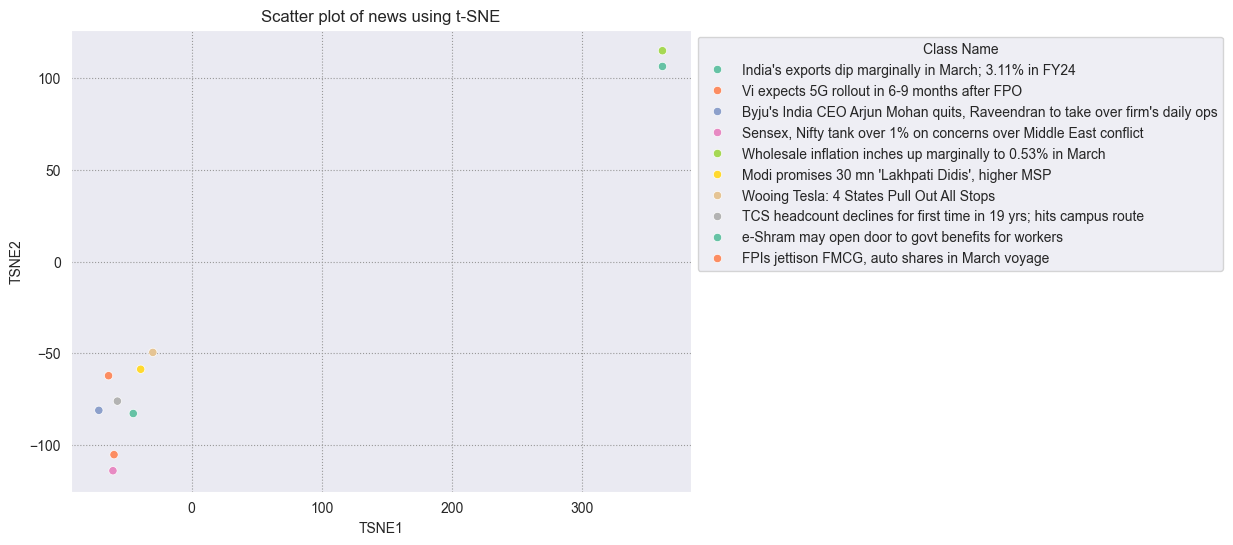

In [29]:
# Plot t-SNE results
fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.show()

# Outlier detection

In [33]:
# Function to get centroids of each class
def get_centroids(df_tsne):
    centroids = df_tsne.groupby('Class Name').mean()
    return centroids

centroids = get_centroids(df_tsne)

# Function to detect outliers
def calculate_euclidean_distance(p1, p2):
    return np.sqrt(np.sum(np.square(p1 - p2)))

def detect_outlier(df, emb_centroids, radius):
    df['Outlier'] = False
    for idx, row in df.iterrows():
        class_name = row['Class Name']  # Get class name of row
        # Compare centroid distances
        dist = calculate_euclidean_distance(np.array([row['TSNE1'], row['TSNE2']]),
                                            np.array([emb_centroids.loc[class_name, 'TSNE1'], emb_centroids.loc[class_name, 'TSNE2']]))
        df.at[idx, 'Outlier'] = dist > radius

    return len(df[df['Outlier']])

In [34]:
# Choose a radius for outlier detection
RADIUS = 50
num_outliers = detect_outlier(df_tsne, centroids, RADIUS)
print("Number of outliers:", num_outliers)

Number of outliers: 0


In [42]:
range_ = np.arange(3, 0.75, 0.02).round(decimals=2).tolist()
num_outliers = []
for i in range_:
  num_outliers.append(detect_outlier(df_tsne, centroids, i))

num_outliers

[]